In [ ]:
import random
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

Helping Functions:

In [ ]:
def new_board(size):
    return np.zeros(shape=(size, size))

In [ ]:
def available_moves(board):
    return np.argwhere(board == 0)

In [ ]:
def check_game_end(board):
    best = max(list(board.sum(axis=0)) +    # columns
               list(board.sum(axis=1)) +    # rows
               [board.trace()] +            # main diagonal
               [np.fliplr(board).trace()],  # other diagonal
               key=abs)
    if abs(best) == board.shape[0]: 
        return np.sign(best)  # winning player, +1 or -1
    if available_moves(board).size == 0:
        return 0  # a draw (otherwise, return None by default)

Players: 

In [ ]:
class Player():
    def new_game(self):
        pass
    def reward(self, value):
        pass

class RandomPlayer(Player):
    def move(self, board):
        return random.choice(available_moves(board))

A *boring* player always picks the *first* available position on the board.

In [ ]:
class BoringPlayer(Player):
    def move(self, board):
        return available_moves(board)[0]

In [ ]:
def play(board, player_objs):
    for player in [+1, -1]:
        player_objs[player].new_game()
    player = +1
    game_end = check_game_end(board)
    while game_end is None:
        move = player_objs[player].move(board)
        board[tuple(move)] = player
        game_end = check_game_end(board)
        player *= -1  # switch players
    for player in [+1, -1]:
        # the reward for wins is +1, and -1 for draws/losses
        reward_value = +1 if player == game_end else -1
        player_objs[player].reward(reward_value)
    return game_end

In [ ]:
# 3x3, random vs. random
random.seed(1)

games = 2000
results=[None] * 2000

for i in range(games):
    results[i] = play(new_board(3), {+1: RandomPlayer(), -1: RandomPlayer()})

P1_win = 0
P2_win = 0
draw = 0

for result in results:
    if result == 1.0:
        P1_win += 1
    elif result == -1.0:
        P2_win += 1
    else:
        draw += 1

print("Player 1 wins ", P1_win, " games")
print("Player 2 wins ", P2_win, " games")
print("Number of games that were draw ", draw)

Player 1 wins  1194  games
Player 2 wins  564  games
Number of games that were draw  242


In [ ]:
def moving(data, value=+1, size = 500):
    binary_data = [x == value for x in data]
    return [sum(binary_data[i-size:i])/size for i in range(size, len(data) + 1)]

def show(results, size=500, title='Moving average of game outcomes',
         first_label='First Player Wins', second_label='Second Player Wins', draw_label='Draw'):
    x_values = range(size, len(results) + 1)
    first = moving(results, value=+1, size=size)
    second = moving(results, value=-1, size=size)
    draw = moving(results, value=0, size=size)
    first, = plt.plot(x_values, first, color='red', label=first_label)
    second, = plt.plot(x_values, second, color='blue', label=second_label)
    draw, = plt.plot(x_values, draw, color='grey', label=draw_label)
    plt.xlim([0, len(results)])
    plt.ylim([0, 1])
    plt.title(title)
    plt.legend(handles=[first, second, draw], loc='best')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.ylabel(f'Rate over last {size} games')
    plt.xlabel('Game index')
    plt.show()

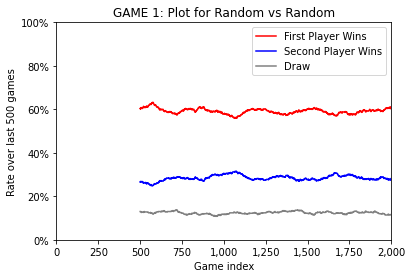

In [ ]:
show (results, title='GAME 1: Plot for Random vs Random')

Player 1 wins  1566  games
Player 2 wins  347  games
Number of games that were draw  87


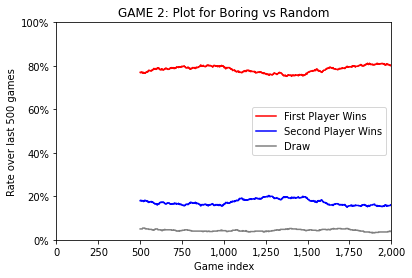

In [ ]:
# 3x3, random vs. boring

random.seed(1)
games = 2000
results=[None] * 2000

for i in range(games):
    results[i] = play(new_board(3), {+1: BoringPlayer(), -1: RandomPlayer()})

P1_win = 0
P2_win = 0
draw = 0

for result in results:
    if result == 1.0:
        P1_win += 1
    elif result == -1.0:
        P2_win += 1
    else:
        draw += 1

print("Player 1 wins ", P1_win, " games")
print("Player 2 wins ", P2_win, " games")
print("Number of games that were draw ", draw)

show (results, title='GAME 2: Plot for Boring vs Random')

**COMMENT**
Boring player always picks the first available position on the board. And even though it isn't a very smart policy, it is better that randomly playing. Hence boring player wins more number of times. 

The Q-function is represented via a very simple single layer with linear activations (essentially, a linear model).



In [ ]:
class Agent(Player):
    # Define single layer model, MSE loss, and SGD optimizer
    def __init__(self, size, seed):
        self.size = size
        self.training = True
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(
            size**2,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)))
        self.model.compile(optimizer='sgd', loss='mean_squared_error')

    # Helper function to predict the Q-function
    def predict_q(self, board):
        return self.model.predict(
            np.array([board.ravel()])).reshape(self.size, self.size)

    # Helper function to train the network
    def fit_q(self, board, q_values):
        self.model.fit(
            np.array([board.ravel()]), np.array([q_values.ravel()]), verbose=0)

    # The agent preserves history, which is reset when a new game starts.
    def new_game(self):
        self.last_move = None
        self.board_history = []
        self.q_history = []


    # The "move" method should use the output of the Q-network to pick the next best move.
    # After picking the move, we call the reward method.

    def move(self, board):

        q_values = self.predict_q(board)
        temp = q_values.copy()
        temp[board != 0] = temp.min() - 1 
        move = np.unravel_index(np.argmax(temp), board.shape)
        value = temp.max()

        if self.last_move is not None:
            self.reward(value)

        self.board_history.append(board.copy())
        self.q_history.append(q_values)
        return move

    # The reward method trains the Q-network, updating the Q-values with 
    # a new estimate for the last move. This is the Bellman update.
    def reward(self, reward_value):
        if not self.training:
            return
        new_q = self.q_history[-1].copy()
        new_q[self.last_move] = reward_value
        self.fit_q(self.board_history[-1], new_q)

Player 1 wins  1225  games
Player 2 wins  627  games
Number of games that were draw  148


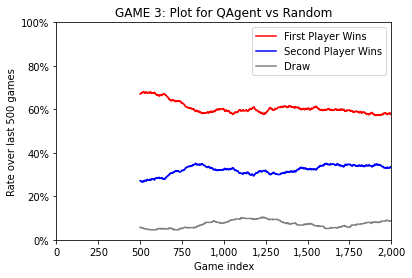

In [ ]:
# 3x3, q-learning vs. random

random.seed(1)
games = 2000
results=[None] * 2000

agent = Agent(3, seed=4)
for i in range(games):
    results[i] = play(new_board(3), {+1: agent, -1: RandomPlayer()})

P1_win = 0
P2_win = 0
draw = 0

for result in results:
    if result == 1.0:
        P1_win += 1
    elif result == -1.0:
        P2_win += 1
    else:
        draw += 1

print("Player 1 wins ", P1_win, " games")
print("Player 2 wins ", P2_win, " games")
print("Number of games that were draw ", draw)

show (results, title='GAME 3: Plot for QAgent vs Random')